# Project 3: Webscraping, APIs, and Natural Language Processing (NLP)

## Part 2: EDA & Modeling

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import random

from sklearn.model_selection import cross_val_score
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

pd.options.display.max_colwidth = 200

In [2]:
games = pd.read_csv('./data/boardgames_and_cardgames.csv')
games.head()

,id,author,selftext,title,subreddit
0,jcepuk,smarter_than_an_oreo,NaN,"I made an Oxygen, Heat, and Generation marker for Terraforming Mars and now I actually remember to advance the generation track. (How-To link attached)",0
1,7ayeig,Tylerjsmall09,"Hey guys! I'm new to Reddit, and I joined specifically to ask this question. I created a scenario-based card game (similar to Exploding Kittens or Cards Against Humanity), and I need help naming i...",Need help with funny card game title!,1
2,7a9boe,SleepyPanda_1945,NaN,[Monster Cry Eternal] Fantasy CCG for Mobile.,1
3,jco7ut,Squirrelhenge,"I've been out of my apartment for 7 months because of water damage from a massive roof leak. None of my possessions were harmed, luckly, and today everything was moved back in. So I've got boxes o...",My stuff just got moved back in to my apartment so how do you organize your collection?,0
4,jd2wz0,backhandle1982,Is anyone able to give me some tips on how to effective strategy for 3 card solitaire. There must be a better way than just doing the face cards then going through the stacks and getting what I ca...,Tips for 3 card solitaire,0


## 1. EDA

### The median length of authors' names

In [3]:
games['author_length'] = [len(name) for name in games['author']]
games['author_length'].describe()

count    4000.00000
mean       11.10500
std         3.61763
min         4.00000
25%         8.00000
50%        10.00000
75%        13.00000
max        20.00000
Name: author_length, dtype: float64

### The distribution of length of authors' names

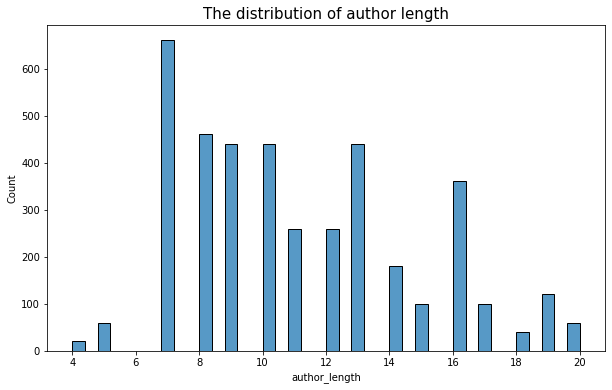

In [4]:
plt.figure(figsize=(10, 6))
sns.histplot(games['author_length'], bins=40)
plt.title('The distribution of author length', fontsize=15);

### The median number of words of title

In [5]:
games['title_length'] = [len(title) for title in games['title']]
games['title_length'].describe()

count    4000.000000
mean       45.845000
std        27.020427
min         9.000000
25%        30.000000
50%        39.000000
75%        52.250000
max       171.000000
Name: title_length, dtype: float64

### The distribution of number of words of title

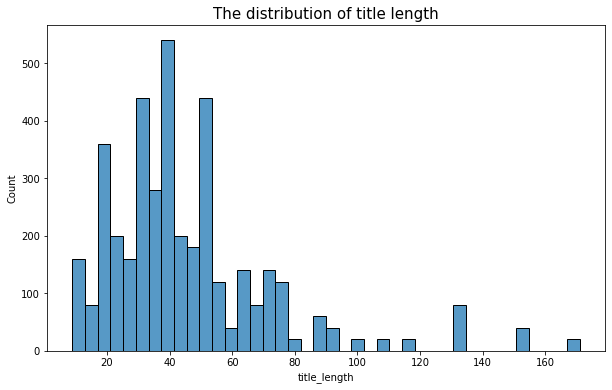

In [6]:
plt.figure(figsize=(10, 6))
sns.histplot(games['title_length'], bins=40)
plt.title('The distribution of title length', fontsize=15);

### The average of letters of author's names between the classes of board games and card games

In [7]:
games.groupby(games['subreddit'])[['author_length']].mean()

,author_length
subreddit,
0,11.53
1,10.68


## Features Extraction

In [8]:
games = games[['title', 'subreddit']]

In [9]:
games.head()

,title,subreddit
0,"I made an Oxygen, Heat, and Generation marker for Terraforming Mars and now I actually remember to advance the generation track. (How-To link attached)",0
1,Need help with funny card game title!,1
2,[Monster Cry Eternal] Fantasy CCG for Mobile.,1
3,My stuff just got moved back in to my apartment so how do you organize your collection?,0
4,Tips for 3 card solitaire,0


### Format dataset for VADER

In [10]:
# preparing a list for SentimentIntensityAnalyzer
corpus = list(games['title'])
corpus[:20]

['I made an Oxygen, Heat, and Generation marker for Terraforming Mars and now I actually remember to advance the generation track. (How-To link attached)',
 'Need help with funny card game title!',
 '[Monster Cry Eternal] Fantasy CCG for Mobile.',
 'My stuff just got moved back in to my apartment so how do you organize your collection?',
 'Tips for 3 card solitaire',
 'What is your favorite card game?',
 'Share your favorite botanical &amp; plant themed games',
 "Why doesn't many people seem to talk about trekking the world?",
 'What is your favorite card game?',
 'A buddy and I started a podcast a few weeks ago...',
 'Need help with funny card game title!',
 'play baccarat - เล่นบาคาร่า - Thailand',
 'I played Betrayal Legacy solo...',
 'Judi poker online terpercaya. Langkah jitu menang dalam permainan judi poker online terpercaya indonesia dan domino online indonesia',
 'Quinns and Tom Vasel decide who is more wrong',
 'Battlecon PnP demo reference cards?',
 'JungleeRummy 25 Rupees F

### Instantiate SentimentIntensityAnalyzer

In [11]:
sia = SentimentIntensityAnalyzer()

# example
sia.polarity_scores(corpus[0])

{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}

In [12]:
# add them as features into dataframe

dicts = []    

for game in corpus:
    scores = sia.polarity_scores(game)
    scores['title'] = game
    dicts.append(scores)

df = pd.DataFrame(dicts)
df.head()

,neg,neu,pos,compound,title
0,0.000,1.000,0.000,0.0000,"I made an Oxygen, Heat, and Generation marker for Terraforming Mars and now I actually remember to advance the generation track. (How-To link attached)"
1,0.000,0.459,0.541,0.7088,Need help with funny card game title!
2,0.341,0.659,0.000,-0.4767,[Monster Cry Eternal] Fantasy CCG for Mobile.
3,0.000,1.000,0.000,0.0000,My stuff just got moved back in to my apartment so how do you organize your collection?
4,0.000,1.000,0.000,0.0000,Tips for 3 card solitaire


In [13]:
games_df = pd.merge(df, games['subreddit'], left_index=True, right_index=True)
games_df

,neg,neu,pos,compound,title,subreddit
0,0.000,1.000,0.000,0.0000,"I made an Oxygen, Heat, and Generation marker for Terraforming Mars and now I actually remember to advance the generation track. (How-To link attached)",0
1,0.000,0.459,0.541,0.7088,Need help with funny card game title!,1
2,0.341,0.659,0.000,-0.4767,[Monster Cry Eternal] Fantasy CCG for Mobile.,1
3,0.000,1.000,0.000,0.0000,My stuff just got moved back in to my apartment so how do you organize your collection?,0
4,0.000,1.000,0.000,0.0000,Tips for 3 card solitaire,0
...,...,...,...,...,...,...
3995,0.000,1.000,0.000,0.0000,The final version of my card game is now available.,1
3996,0.000,0.556,0.444,0.3400,Anyone play Trudvang Legends?,0
3997,0.000,1.000,0.000,0.0000,Ace2Three Paytm Offer,1
3998,0.000,0.756,0.244,0.4404,My wife does not consider board games a way to relax,0


In [14]:
# games['title'] = games['title'].replace('#\S+', '', regex=True). replace('\n\n\S+', '', regex=True)

### Split data intro training and test sets

In [15]:
X = games_df[['title', 'compound', 'neg', 'neu', 'pos']]
y = games_df['subreddit']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

### Baseline accuracy

In [16]:
y.value_counts(normalize=True)

1    0.5
0    0.5
Name: subreddit, dtype: float64

### CountVectorizer

In [17]:
cvec = CountVectorizer(stop_words = 'english', max_features = 300)

X_train_cv = cvec.fit_transform(X_train['title'])
X_test_cv = cvec.transform(X_test['title'])

In [18]:
# visualize CountVectorizer

X_train_df = pd.DataFrame(X_train_cv.todense(), columns=cvec.get_feature_names())
X_test_df = pd.DataFrame(X_test_cv.todense(), columns=cvec.get_feature_names())

In [19]:
# merge training data and testing data
# sequency the indices

total_X = X_train_df.append(X_test_df)
total_X.reset_index(drop=True, inplace=True)
total_X

total = pd.merge(total_X, y, left_index=True, right_index=True)

In [20]:
total.drop('title', axis=1, inplace=True)

In [21]:
total

,000,10,18,18xx,1930,20,2020,2038,25,2ed,...,wise,wonders,works,world,wrong,wsig,years,นบาคาร,เล,subreddit
0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
3996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [22]:
# merge features: compound, neg, neu, pos

combine_df = pd.merge(games_df[['compound', 'neg', 'neu', 'pos']], total, left_index=True, right_index=True)
combine_df

,compound,neg,neu,pos,000,10,18,18xx,1930,20,...,wise,wonders,works,world,wrong,wsig,years,นบาคาร,เล,subreddit
0,0.0000,0.000,1.000,0.000,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,0.7088,0.000,0.459,0.541,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,-0.4767,0.341,0.659,0.000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0.0000,0.000,1.000,0.000,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0.0000,0.000,1.000,0.000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,0.0000,0.000,1.000,0.000,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
3996,0.3400,0.000,0.556,0.444,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3997,0.0000,0.000,1.000,0.000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3998,0.4404,0.000,0.756,0.244,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Visualized the most / least 20 most common words in dataset

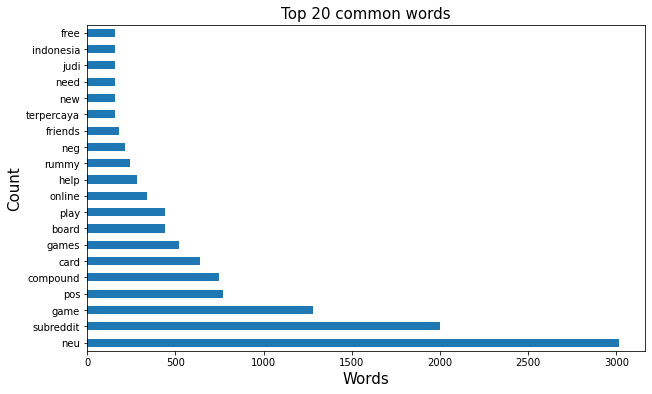

In [23]:
plt.figure(figsize=(10, 6))
combine_df.sum().sort_values(ascending=False)[:20].plot(kind='barh')
plt.title('Top 20 common words', fontsize=15)
plt.xlabel('Words', fontsize=15)
plt.ylabel('Count', fontsize=15);

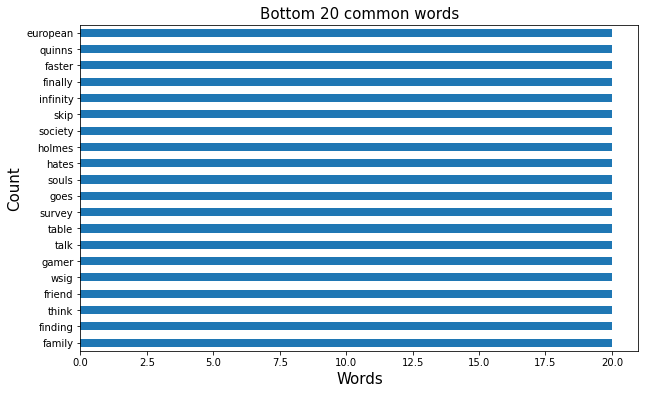

In [24]:
plt.figure(figsize=(10, 6))
combine_df.sum().sort_values(ascending=True)[:20].plot(kind='barh')
plt.title('Bottom 20 common words', fontsize=15)
plt.xlabel('Words', fontsize=15)
plt.ylabel('Count', fontsize=15);

## 2. Modeling

### Redefine X and y

In [25]:
X = combine_df.drop('subreddit', axis=1)
y = combine_df['subreddit']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

### Logistic Regression

In [26]:
lr = LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression()

In [27]:
cross_val_score(lr, X_train, y_train).mean()

0.6023333333333334

In [28]:
print('Train score: ', lr.score(X_train, y_train))
print('Test score: ', lr.score(X_test, y_test))

Train score:  0.6373333333333333
Test score:  0.613


**Hyperparameter tuning**

In [29]:
params = ([{'penalty': ['l1','l2'], 
            'C': [0.001, 0.1, 1.0, 10, 100]}])

**GridSearch**

In [30]:
gs = GridSearchCV(lr, param_grid = params, cv = 5)

In [31]:
gs.fit(X_train, y_train)

/Users/zhuoquanchen/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/zhuoquanchen/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/zhuoquanchen/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/zhuoquanchen/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
/Users/zhuoquanchen/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_valida

/Users/zhuoquanchen/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/zhuoquanchen/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid=[{'C': [0.001, 0.1, 1.0, 10, 100],
                          'penalty': ['l1', 'l2']}])

In [32]:
gs.best_params_

{'C': 0.001, 'penalty': 'l2'}

In [33]:
gs.best_score_

0.6206666666666667

In [34]:
print('Train score: ', gs.score(X_train, y_train))
print('Test score: ', gs.score(X_test, y_test))

Train score:  0.6223333333333333
Test score:  0.636


**Model evaluation**

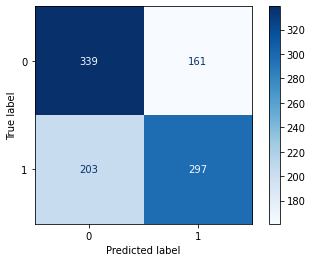

In [35]:
preds = gs.predict(X_test)
tp, fp, fn, tn = confusion_matrix(y_test, preds).ravel()

plot_confusion_matrix(gs, X_test, y_test, cmap='Blues', values_format='d');

In [36]:
Accuracy = (tp + tn) / (tp + fp + fn + tn)
Accuracy

0.636

In [37]:
Sensitivity = tp / (tp + fn)
Sensitivity

0.6254612546125461

In [38]:
Specificity = tn / (tn + fp)
Specificity

0.648471615720524

### RandomForest

In [39]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [40]:
print('Train score: ', rf.score(X_train, y_train))
print('Test score: ', rf.score(X_test, y_test))

Train score:  0.866
Test score:  0.813


**Hyperparameter tuning**

In [41]:
params = {'n_estimators': [1, 10, 50, 100], 
         'max_depth': [None,1, 2, 3],
         'max_features':['auto', None]}

**GridSearch**

In [42]:
gs = GridSearchCV(rf, param_grid=params)
gs.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [None, 1, 2, 3],
                         'max_features': ['auto', None],
                         'n_estimators': [1, 10, 50, 100]})

In [43]:
gs.best_params_

{'max_depth': None, 'max_features': None, 'n_estimators': 50}

In [44]:
gs.best_score_

0.834

In [45]:
print('Train score: ', gs.score(X_train, y_train))
print('Test score: ', gs.score(X_test, y_test))

Train score:  0.866
Test score:  0.834


**Model evaluation**

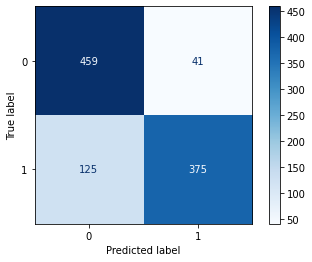

In [46]:
preds = gs.predict(X_test)
tp, fp, fn, tn = confusion_matrix(y_test, preds).ravel()

plot_confusion_matrix(gs, X_test, y_test, cmap='Blues', values_format='d');

In [47]:
Accuracy = (tp + tn) / (tp + fp + fn + tn)
Accuracy

0.834

In [48]:
Sensitivity = tp / (tp + fn)
Sensitivity

0.785958904109589

In [49]:
Specificity = tn / (tn + fp)
Specificity

0.9014423076923077

### Bagging

In [50]:
bag = BaggingClassifier()

In [51]:
bag.fit(X_train, y_train)

BaggingClassifier()

In [52]:
bag.score(X_train, y_train), bag.score(X_test, y_test)

(0.865, 0.827)

**Hyperparameter tuning**

In [53]:
# params = [{'n_estimators': [20,50, 100],
#            'max_samples': [0.5, 1.0, 2.0, 3.0],
#            'max_features': ['auto', 'sqrt', 'log2', None]}]

**GridSearch**

In [54]:
# gs = GridSearchCV(bag, params, cv =5)

In [55]:
# gs.best_params_

In [56]:
# gs.best_score_

In [57]:
# print('Train score: ', gs.score(X_train, y_train))
# print('Test score: ', gs.score(X_test, y_test))

### Gradient Boosting Regression Tree

In [58]:
gbrt = GradientBoostingRegressor(max_depth=1,random_state=42)
gbrt.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=1, random_state=42)

In [59]:
print('Train score: ', gbrt.score(X_train, y_train))
print('Test score: ', gbrt.score(X_test, y_test))

Train score:  0.2674179976076487
Test score:  0.2598302530103831


**Hyperparameter tuning**

In [60]:
gs.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [None, 1, 2, 3],
                         'max_features': ['auto', None],
                         'n_estimators': [1, 10, 50, 100]})

In [61]:
params = [{'n_estimators': [20,50, 100],
           'max_samples': [200, 300, 400],
           'max_features': ['auto', 'sqrt', 'log2', None]}]

**GridSearch**

In [62]:
gs.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [None, 1, 2, 3],
                         'max_features': ['auto', None],
                         'n_estimators': [1, 10, 50, 100]})

In [63]:
gs.best_params_

{'max_depth': None, 'max_features': None, 'n_estimators': 50}

In [64]:
gs.best_score_

0.834

In [65]:
print('Train score: ', gs.score(X_train, y_train))
print('Test score: ', gs.score(X_test, y_test))

Train score:  0.866
Test score:  0.834


**Model evaluation**

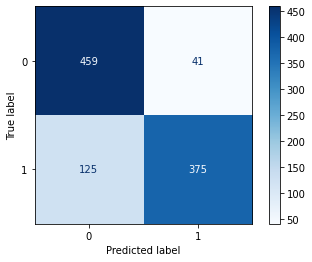

In [66]:
preds = gs.predict(X_test)
tp, fp, fn, tn = confusion_matrix(y_test, preds).ravel()

plot_confusion_matrix(gs, X_test, y_test, cmap='Blues', values_format='d');

In [67]:
Accuracy = (tp + tn) / (tp + fp + fn + tn)
Accuracy

0.834

In [68]:
Sensitivity = tp / (tp + fn)
Sensitivity

0.785958904109589

In [69]:
Specificity = tn / (tn + fp)
Specificity

0.9014423076923077